# Trabajo Practico - TSA

## Introduccion

Se escoje un dataset de kaggle que contiene el indice de vegetacion de 50k puntos distintos de sudamerica.

In [47]:
#%matplotlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa as tsa
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

In [2]:
PATH = r'C:\Users\agust\Documents'

In [3]:
DATASET = r'\Datasets\soybean_southamerica_mod13q1_evi_2000_2019.csv'

In [4]:
data = pd.read_csv(PATH+DATASET)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22850000 entries, 0 to 22849999
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   fid        int64  
 1   date       object 
 2   timestamp  int64  
 3   evi        float64
dtypes: float64(1), int64(2), object(1)
memory usage: 697.3+ MB


Se toma aleatoriamente el field id 14880 para el desarrollo de este trabajo practico:

In [6]:
fid_14880 = data.where(data.fid==14880).dropna()

In [7]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 354 to 2280354
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fid        457 non-null    float64
 1   date       457 non-null    object 
 2   timestamp  457 non-null    float64
 3   evi        457 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.9+ KB


In [8]:
fid_14880.head()

,fid,date,timestamp,evi
354,14880.0,2000-02-18,9.508320e+11,0.4750
5354,14880.0,2000-03-05,9.522144e+11,0.3851
10354,14880.0,2000-03-21,9.535968e+11,0.4581
15354,14880.0,2000-04-06,9.549792e+11,0.3466
20354,14880.0,2000-04-22,9.563616e+11,0.3867


Se quitan las columnas fid y timestamp

In [9]:
fid_14880.drop(labels=['fid', 'timestamp'], axis=1, inplace=True)

Se convierte la columna Date en tipo 'datetime'

In [10]:
fid_14880['date'] = pd.to_datetime(fid_14880['date'], format="%Y-%m-%d")

In [11]:
fid_14880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 354 to 2280354
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    457 non-null    datetime64[ns]
 1   evi     457 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.7 KB


In [12]:
fid_14880.head()

,date,evi
354,2000-02-18,0.4750
5354,2000-03-05,0.3851
10354,2000-03-21,0.4581
15354,2000-04-06,0.3466
20354,2000-04-22,0.3867


In [13]:
fid_14880.describe()

,evi
count,457.000000
mean,0.408142
std,0.087391
min,0.182400
25%,0.347100
50%,0.404700
75%,0.465900
max,0.773800


## Punto 1:
* Graficar una serie a partir de un dataset relevante. Explicar observaciones.

<AxesSubplot:xlabel='date'>

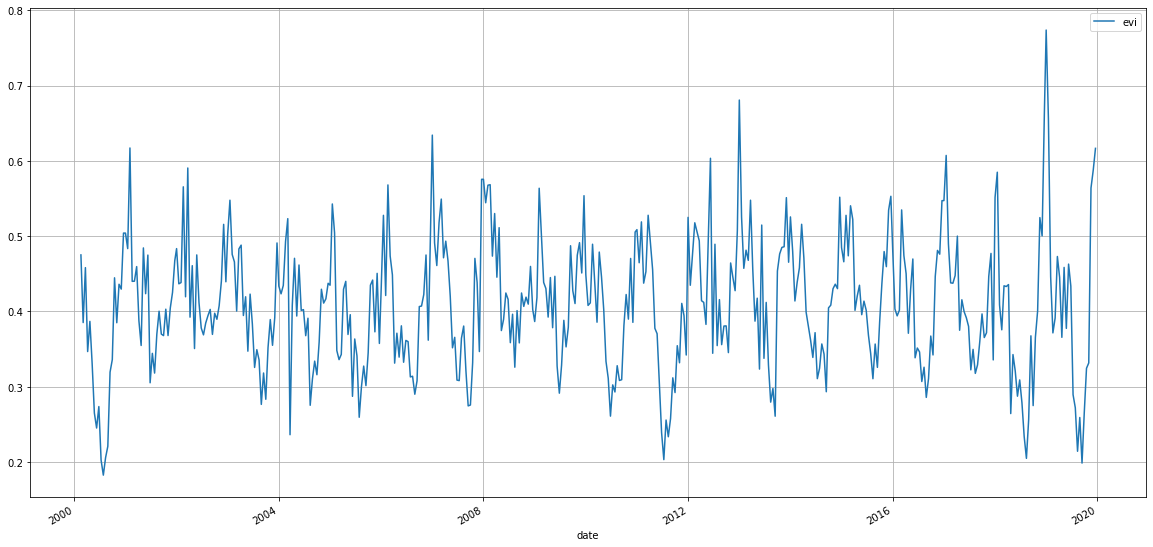

In [14]:
fid_14880.plot(x='date',y='evi',figsize=(20,10), grid=True)

En la serie de tiempo elegida se puede observar un comportamiento periodico y dada la naturaleza del dataset se puede suponer que depende de los ciclos del cultivos, con un periodo observable que pareceria ser anual.

Se puede diferencial cada periodo a pesar de ser una señal muy ruidosa.

<AxesSubplot:ylabel='Frequency'>

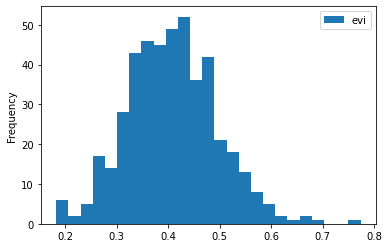

In [15]:
fid_14880.plot(x='date',y='evi', kind='hist', bins = 25)

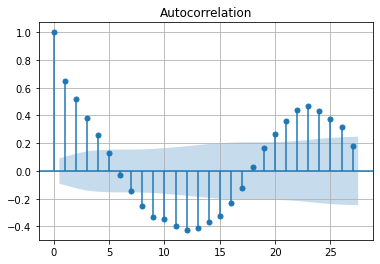

In [57]:
plot_acf(fid_14880.evi.values)
plt.grid(True)
plt.show()

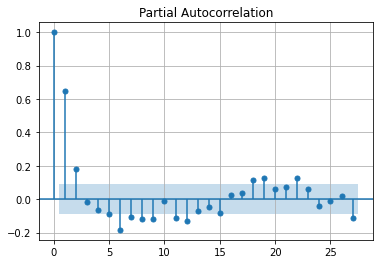

In [56]:
plot_pacf(fid_14880.evi.values)
plt.grid(True)
plt.show()

## Punto 2:
* Descomponer una serie de tiempo usando el modelo aditivo y el modelo multiplicativo.

La descompocision se realiza de tal modo que nos queden los siguientes modelos:

Modelo Aditivo:

    Y(t) = T(t) + S(t) + C(t) + e(t)

Modelo Multiplicativo:

    Y(t) = T(t) * S(t) * C(t) * e(t)

Con:

T(t): tendencia.
S(t): variación estacional.
C(t): Componente cíclico.
e(t): Componente aleatoria.

En un primer paso utilizaremos la funcion seasonal_descompose de la libreria statsmodels. Esta funcion nos devolvera ambos modelos antes descriptos, sin considerar la componente ciclica. Modelos de la funcion seasonal_descompose:
   * The additive model is Y[t] = T[t] + S[t] + e[t]
   * The multiplicative model is Y[t] = T[t] * S[t] * e[t]
   
Los parametros de esta funcion son:
   * Los valores de la serie de tiepo en cuestion
   * El tipo de modelo a calcular
   * El periodo de la serie. En este caso el periodo es 21, ya que de la visualizacion de la grafica se desprende que hay un ciclo por año.

In [16]:
fid_14880_2 = fid_14880
fid_14880_2 = fid_14880_2.set_index(pd.DatetimeIndex(fid_14880_2['date']))
fid_14880_2.sort_index(ascending=True, inplace=True)
fid_14880_2 = fid_14880_2['evi']

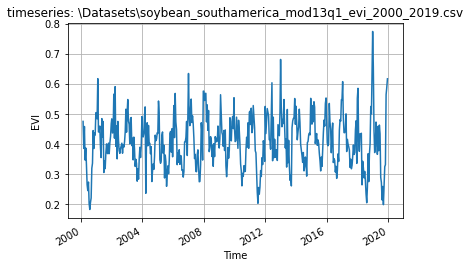

In [17]:
fid_14880_2.plot()
plt.title("timeseries: " + DATASET)
plt.xlabel("Time")
plt.ylabel("EVI")
plt.grid()
plt.show()

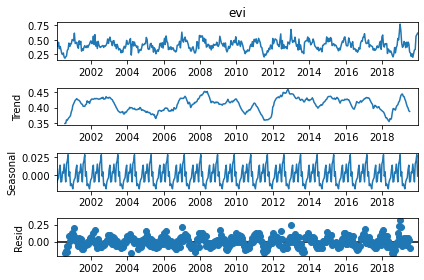

In [53]:
# Additive
addit = sm.tsa.seasonal_decompose(fid_14880_2, model='additive', period = 21)
addit.plot()
plt.show()

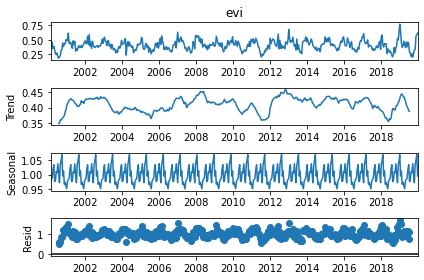

In [52]:
# Multiplicative
mult = sm.tsa.seasonal_decompose(fid_14880_2, model='multiplicative', period = 21)
mult.plot()
plt.show()

##### Calculo de la tendencia como funcion cuadratica

A continuacion se estimara la tendencia como una funcion cuadtratica: 

In [20]:
def objective(t,a,b,c):
    return a*t**2+b*t+c

In [21]:
x = fid_14880.date.values

In [22]:
x = pd.to_numeric(fid_14880['date']).values

In [23]:
y = fid_14880.evi.values

In [24]:
x = (x-x.min())/(x.max()-x.min())

In [25]:
popt, _ = curve_fit(objective, x, y)
a,b,c = popt

Parametros de T(t) = a t^2 + b t + c

In [26]:
print('a:', a)
print('b:', b)
print('c:', c)

a: -0.09052178160947655
b: 0.10666080174568526
c: 0.38501384871166233


In [27]:
y_tend = objective(x,a,b,c)

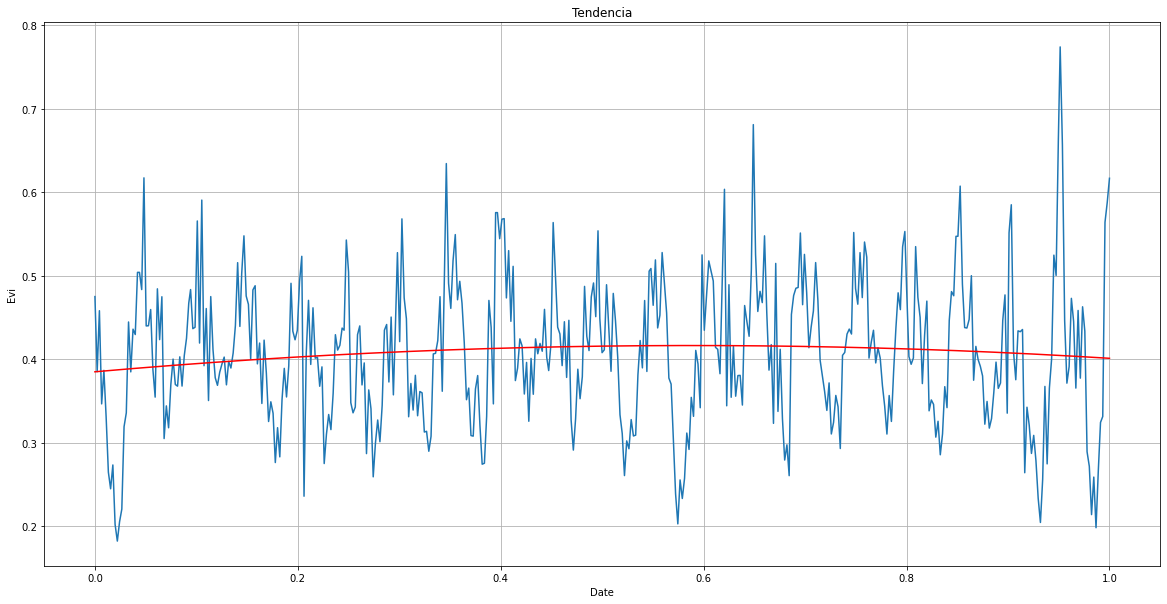

In [28]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x, y)
ax.plot(x,y_tend, color = 'red')
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Evi")
ax.grid(True)
plt.show()

#### Metodo de cuadrados minimos

In [50]:
Q = y - y_tend

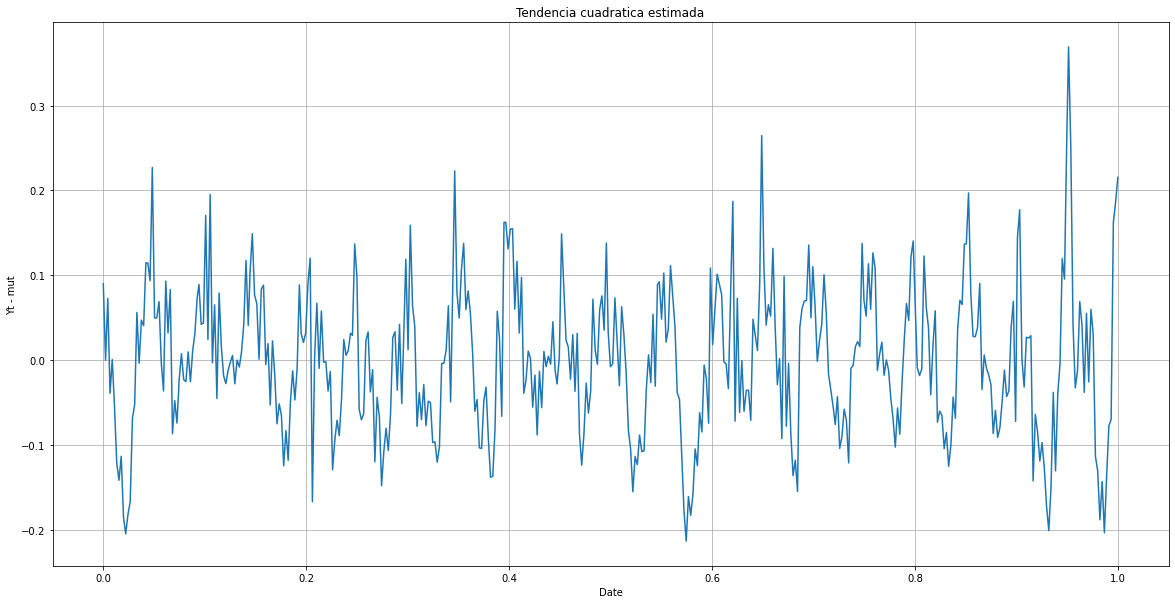

In [51]:
fig, ax = plt.subplots(1,figsize=(20, 10))
ax.plot(x, Q)
ax.plot(x,Q)
ax.set_title("Tendencia cuadratica estimada")
ax.set_xlabel("Date")
ax.set_ylabel("Yt - mut")
ax.grid(True)
plt.show()

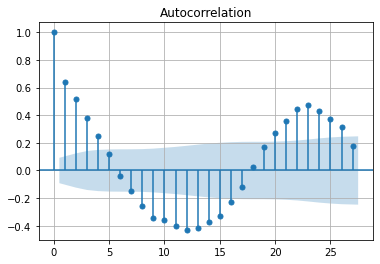

In [58]:
plot_acf(Q)
plt.grid(True)
plt.show()

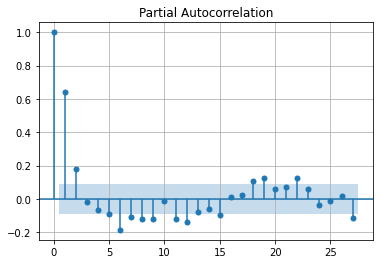

In [66]:
plot_pacf(Q)
plt.grid(True)
plt.show()

##### Calculo de componente ciclica

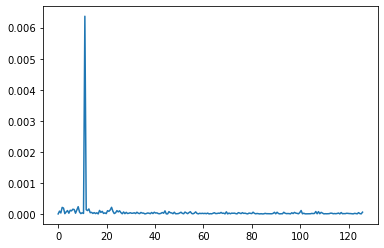

In [39]:
G, Pyy_den = signal.periodogram(y, 252)
plt.plot(G, Pyy_den)
plt.show()

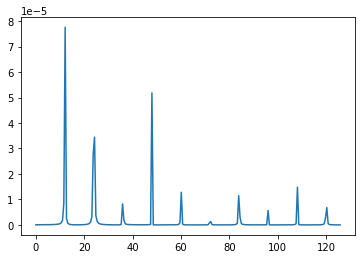

In [30]:
G, Pyy_den = signal.periodogram(addit.seasonal, 252)
plt.plot(G, Pyy_den)
plt.show()

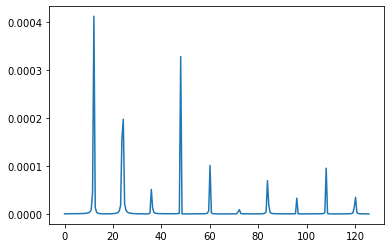

In [31]:
G, Pyy_den = signal.periodogram(mult.seasonal, 252)
plt.plot(G, Pyy_den)
plt.show()

## Punto 3:
* Aplicar los modelos vistos en clase:
    - Para la tendencia usar cuadrados mínimos y expresar los coeficientes. Sacar conclusiones acerca de la validez del modelo
    - Componente cíclica: usar análisis espectral y hallar las frecuencias principales
    - Para la componente estacional usar ARIMA
    - Para la componente de error obtener R_k, C_k

In [32]:

interval = 1
diff = list()
for i in range(interval, len(fid_14880_2)):
    value = fid_14880_2[i] - fid_14880_2[i - interval]
    diff.append(value)

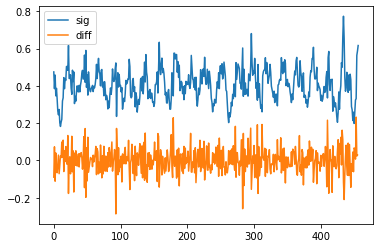

In [33]:
plt.plot(fid_14880_2.values)
plt.plot(diff)
plt.legend(['sig','diff'])
plt.show()

In [34]:
diff1=diff
dataset=diff
interval=1
diff = list()
for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
diff2=diff

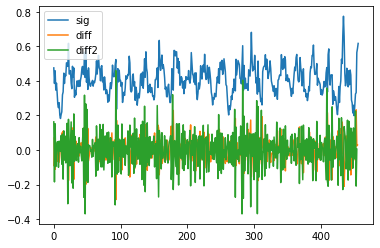

In [35]:
plt.plot(fid_14880_2.values)
plt.plot(diff1)
plt.plot(diff2)
plt.legend(['sig','diff','diff2'])
plt.show()

In [36]:
N = 20
dataframe = pd.Series(pd.concat([pd.Series(diff[0]),pd.Series(diff)], axis=0))
ts=pd.DataFrame(dataframe.values)
rows=int(len(ts)/N)
data2 = ts.values.reshape(24,-1)

In [37]:
betas=data2.mean(axis=0)
betas

array([-0.0356625 ,  0.054375  , -0.04647083,  0.01245417,  0.00979167,
       -0.02335417,  0.0271875 , -0.02030417,  0.034025  , -0.02261667,
       -0.0160875 ,  0.021675  , -0.00449167, -0.01661667,  0.02599167,
        0.00935   , -0.01335833, -0.04564167,  0.06149583])

NameError: name 'sample' is not defined

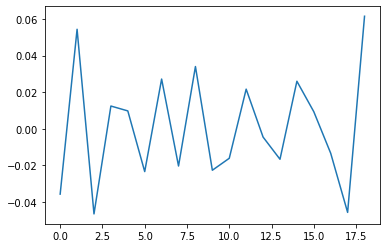

In [38]:
plt.plot(betas)
plt.plot(data2[sample,:])
plt.plot(data2[sample,:]-betas)
plt.legend(['betas','data2','data-betas'])
plt.show()


## Punto 4:
* Predicciones:
    - Realizar predicciones usando (S)ARIMA
    - Realizar predicciones usando redes neuronales LSTM
    - Extraer conclusiones